In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split as tts,RepeatedKFold ,cross_val_score ,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_csv(r"C:\Users\SURAJ\Downloads\Ridge_car_data.txt.csv")
df.dropna(inplace=True)
df.drop("car name",axis=1,inplace=True)
df.head()

,mpg,cylinders,displacement,weight,acceleration,model year,horsepower,origin
0,18.0,8,307.0,3504,12.0,70,130.0,1
1,15.0,8,350.0,3693,11.5,70,165.0,1
2,18.0,8,318.0,3436,11.0,70,150.0,1
3,16.0,8,304.0,3433,12.0,70,150.0,1
4,17.0,8,302.0,3449,10.5,70,140.0,1


from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_scaled=scale.fit_transform(df)

df= pd.DataFrame({
    'mpg' : df_scaled[:,0],
    'cylinders' :df_scaled[:,1],
    'displacement' : df_scaled[:,2],
    'weight' : df_scaled[:,3],
    'acceleration' : df_scaled[:,4],
    'model year' :df_scaled[:,5],
    'horsepower' : df_scaled[:,6],
    'origin' : df_scaled[:,7]
})
df.head()

<AxesSubplot: >

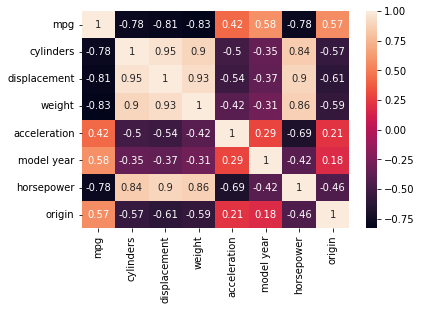

In [3]:
sns.heatmap(df.corr(),annot=True)

In [4]:
ind = df[['mpg']]
dep = df.drop("mpg",axis=1)

# Model traning 

In [5]:
X_train,X_test,y_train,y_test = tts(dep,ind,train_size=0.8,random_state=1)

print(X_test.shape)
print(X_train.shape)

(79, 7)
(313, 7)


# Linear Regression

In [6]:
import statsmodels.api as sm
x1=sm.add_constant(X_train)
model_l2=sm.OLS(y_train,x1).fit()
model_l2.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.814    
Dependent Variable: mpg              AIC:                1645.0046
Date:               2023-05-16 13:06 BIC:                1674.9742
No. Observations:   313              Log-Likelihood:     -814.50  
Df Model:           7                F-statistic:        195.9    
Df Residuals:       305              Prob (F-statistic): 7.51e-109
R-squared:          0.818            Scale:              10.941   
------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------
const            -18.7577   5.0922 -3.6836 0.0003 -28.7781 -8.7373
cylinders         -0.1453   0.3677 -0.3951 0.6930  -0.8688  0.5782
displacement       0.0175   0.0087  2.0106 0.0452   0.0004  0.0345
weight            -0.0071   0.0008 -8.9888 0.0000  -0.0086 -0.0055
acceleration       0.1895   0.1106  1.7130 0.0877  -0.0282  0.4072
model year         0.7388   0.0567 13.0255 0.0000   0.6272  0.8504
horsepower        -0.0067   0.0153 -0.4364 0.6628  -0.0368  0.0234
origin             1.3764   0.3049  4.5137 0.0000   0.7763  1.9765
------------------------------------------------------------------
Omnibus:               20.663       Durbin-Watson:          2.094 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       33.086
Skew:                  0.433        Prob(JB):               0.000 
Kurtosis:              4.337        Condition No.:          84174 
==================================================================
* The condition number is large (8e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

# Ridge Regression

In [7]:
Score = []
coeff = []
intercept = []
R_square = []
Adj_rsq =[]
MSE_train = []
MSE_test = []
lambda_ =np.arange(-80,10,4)
alp = lambda_
alpha = {"alpha":lambda_}

for i in alp:
    model = Ridge(alpha=i)
    fold = RepeatedKFold(n_splits=4, n_repeats=5,random_state=1)
    cv = cross_val_score(model, X_train,y_train,scoring="neg_mean_absolute_error",cv=fold,n_jobs=-1)
    grd = GridSearchCV(Ridge(),alpha,scoring="neg_mean_squared_error",cv=fold,n_jobs=-1)
    grd.fit(X_train,y_train)
    Score.append(np.mean(np.absolute(cv)))
    # model fitting
    rd = model.fit(X_train,y_train)
    coeff.append(rd.coef_)
    intercept.append(rd.intercept_)
    R_square.append(r2_score(rd.predict(X_test),y_test))
    Adj_rsq.append(1 - (1 - np.mean(np.array(R_square)) * (len(X_test) - 1) / (len(X_test) - len(X_test.columns) - 1)))
    MSE_train.append(mean_squared_error(rd.predict(X_train),y_train))
    MSE_test.append(mean_squared_error(rd.predict(X_test),y_test))


In [8]:
int=pd.DataFrame(intercept)
int.columns = ["intercept"]
coeffs = pd.DataFrame(np.matrix(np.array(coeff)),columns=X_train.columns)
rdg_ = pd.DataFrame({
    "alpha" : alp,
    "R_squre" : R_square,
    "Adj_rsquare" :Adj_rsq,
    "MSE_train" : MSE_train,
    "MSE_test" : MSE_test
    
})
rdg_data= pd.concat([rdg_,int,coeffs],axis=1)
rdg_data

,alpha,R_squre,Adj_rsquare,MSE_train,MSE_test,intercept,cylinders,displacement,weight,acceleration,model year,horsepower,origin
0,-80,0.123734,0.135933,257.716412,353.235502,-82.155992,30.493310,-0.495831,-0.012838,0.243795,0.832860,0.133094,-5.007442
1,-76,0.352476,0.261580,67.787053,71.949347,0.164502,-13.826796,0.269097,-0.004053,0.243036,0.700324,-0.097085,7.507870
2,-72,0.686557,0.425802,19.912163,18.878239,-15.324770,-5.041951,0.115192,-0.005850,0.236730,0.727801,-0.048339,4.686253
3,-68,0.749807,0.525284,14.426779,13.929220,-18.694018,-2.891246,0.076383,-0.006316,0.231833,0.734966,-0.034888,3.827410
4,-64,0.767052,0.588763,12.724932,12.707823,-19.925253,-1.939560,0.058538,-0.006537,0.227573,0.738291,-0.028055,3.348121
5,-60,0.773213,0.632210,11.955645,12.274872,-20.430892,-1.412156,0.048209,-0.006669,0.223764,0.740157,-0.023703,3.017739
6,-56,0.775742,0.663640,11.531821,12.089379,-20.618854,-1.081970,0.041433,-0.006757,0.220310,0.741282,-0.020594,2.765800
7,-52,0.776814,0.687360,11.269447,12.001266,-20.647762,-0.858655,0.036625,-0.006821,0.217144,0.741965,-0.018216,2.562507
8,-48,0.777216,0.705859,11.094781,11.957760,-20.590591,-0.699297,0.033021,-0.006870,0.214220,0.742355,-0.016317,2.392587
9,-44,0.777278,0.720664,10.972955,11.937074,-20.484727,-0.580989,0.030211,-0.006908,0.211500,0.742536,-0.014755,2.247139


In [9]:
print('Alpha:',grd.best_params_)
print('Best_score:',grd.best_score_)

Alpha: {'alpha': 8}
Best_score: -11.434035586622326


Text(0.5, 1.0, 'Lambda V/c coefficeints')

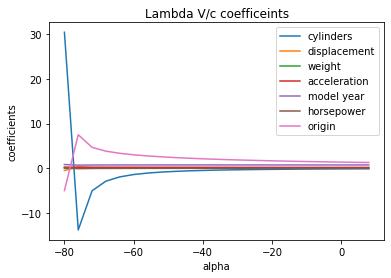

In [10]:
ax= plt.gca()

ax.plot(rdg_data["alpha"],coeffs,label = X_test.columns)
plt.legend()
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lambda V/c coefficeints')

Text(0.5, 1.0, 'Overfitting and Underfitting')

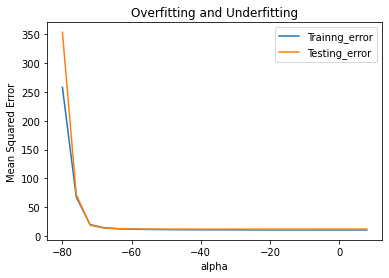

In [11]:
# overfit _ underfit 
plt.plot(lambda_,rdg_data.MSE_train,label="Trainng_error")
plt.plot(lambda_,rdg_data.MSE_test,label="Testing_error")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error')
plt.title('Overfitting and Underfitting')

# Lasso Regression

In [12]:
from sklearn.linear_model import Lasso
Score = []
coeff = []
intercept = []
R_square = []
Adj_rsq =[]
MSE_train = []
MSE_test = []
lambda_ =np.arange(-5,15,4)
alp = lambda_
alpha = {"alpha":lambda_}
for i in alp:
    model = Lasso(alpha=i)
    fold = RepeatedKFold(n_splits=7, n_repeats=5,random_state=1)
    cv = cross_val_score(model, X_train,y_train,scoring="neg_mean_absolute_error",cv=fold,n_jobs=-1)
    grd = GridSearchCV(Lasso(),alpha,scoring="neg_mean_squared_error",cv=fold,n_jobs=-1)
    grd.fit(X_train,y_train)
    Score.append(np.mean(np.absolute(cv)))
    # model fitting
    lass = model.fit(X_train,y_train)
    coeff.append(lass.coef_)
    intercept.append(lass.intercept_)
    R_square.append(r2_score(lass.predict(X_test),y_test))
    Adj_rsq.append(1 - (1 - np.mean(np.array(R_square)) * (len(X_test) - 1) / (len(X_test) - len(X_test.columns) - 1)))
    MSE_train.append(mean_squared_error(lass.predict(X_train),y_train))
    MSE_test.append(mean_squared_error(lass.predict(X_test),y_test))


In [13]:
int=pd.DataFrame(intercept)
int.columns = ["intercept"]
coeffs_lasso = pd.DataFrame(np.matrix(np.array(coeff)),columns=dep.columns)
rdg_ = pd.DataFrame({
    "alpha" : alp,
    "R_squre" : R_square,
    "Adj_rsquare" :Adj_rsq,
    "MSE_train" : MSE_train,
    "MSE_test" : MSE_test
    
})
rdg_data_lasso= pd.concat([rdg_,int,coeffs_lasso],axis=1)
rdg_data_lasso

,alpha,R_squre,Adj_rsquare,MSE_train,MSE_test,intercept,cylinders,displacement,weight,acceleration,model year,horsepower,origin
0,-5,0.146670,0.161131,209.555193,263.230698,-76.652114,-21.556485,0.484003,-0.010123,2.330751,1.199917,0.005539,16.646376
1,-1,0.685727,0.457232,18.628452,19.385952,-28.344537,-4.452926,0.111946,-0.007316,0.556629,0.819053,-0.017575,4.482975
2,3,0.716459,0.567187,12.206487,13.552629,7.034546,-0.000000,-0.000063,-0.006461,0.000000,0.483227,-0.011429,0.000000
3,7,0.595878,0.589047,15.530406,17.238123,33.364681,-0.000000,-0.005254,-0.006076,0.000000,0.141081,-0.016360,0.000000
4,11,0.521609,0.585844,17.801944,19.614243,44.343931,-0.000000,-0.007042,-0.006203,0.000000,0.000000,-0.012019,0.000000


In [14]:
print('Alpha:',grd.best_params_)
print('Best_score:',grd.best_score_)

Alpha: {'alpha': 3}
Best_score: -12.656609100754794


Text(0.5, 1.0, 'Lambda V/c coefficeints')

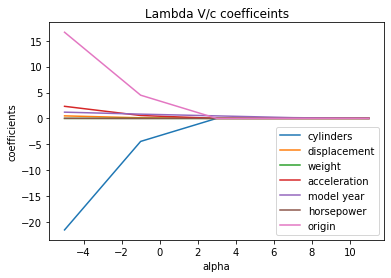

In [15]:
ax= plt.gca()

ax.plot(rdg_data_lasso["alpha"],coeffs_lasso,label = X_test.columns)
plt.legend()
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lambda V/c coefficeints')

Text(0.5, 1.0, 'Overfitting and Underfitting')

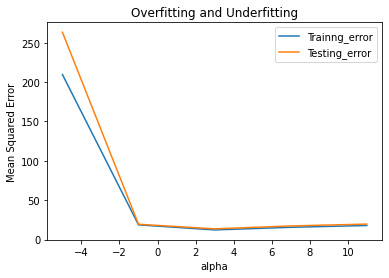

In [16]:
# overfit _ underfit 
plt.plot(lambda_,rdg_data_lasso.MSE_train,label="Trainng_error")
plt.plot(lambda_,rdg_data_lasso.MSE_test,label="Testing_error")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error')
plt.title('Overfitting and Underfitting')

In [17]:
print("beat_lambda : ",grd.best_params_)
print('mean_squared_error : ',-grd.best_score_)

beat_lambda :  {'alpha': 3}
mean_squared_error :  12.656609100754794
